In [1]:
import os
import time
import numpy as np
import copy
import matplotlib.pyplot as plt
import scipy as sp
from mri.operators import FFT,WaveletN, OWL
from modopt.opt.proximity import GroupLASSO, IdentityProx

from online.generators.column import Column2DKspaceGenerator,  DataOnlyKspaceGenerator
from online.reconstructors.fast import OnlineReconstructor
from online.operators.fourier import ColumnFFT
from utils import implot, load_data, create_cartesian_metrics
from online.metrics import crop_center_square, ssos

/home/pac/gits/phd/pysap-mri/mri/operators/fourier/cartesian.py:34: UserWarning: pynufft python package has not been found. If needed use the master release. Till then you cannot use NUFFT on GPU
  warnings.warn("pynufft python package has not been found. If needed use "
/home/pac/gits/phd/pysap-mri/mri/operators/fourier/non_cartesian.py:42: UserWarning: gpuNUFFT python package has not been found. If needed please check on how to install in README
  warnings.warn("gpuNUFFT python package has not been found. If needed "


In [2]:
DATA_DIR = "data/"
RESULT_DIR = "data/results/"
N_JOBS = 1
results = dict()

full_k, real_img, mask_loc, final_mask = load_data(DATA_DIR,1)
# use mono-coil data
full_k = sp.fft.ifftshift(sp.fft.fft2(real_img,s=(320,320),norm="ortho"))
final_mask = crop_center_square(final_mask)
final_k = full_k * final_mask

(16, 640, 320) complex128
(320, 320) float32
file_brain_AXFLAIR_200_6002462.h5
1


# Type II reconstruction

In [3]:
line_kspace_gen = DataOnlyKspaceGenerator(final_k, mask_loc)
K_DIM = line_kspace_gen.shape[-2:]
N_COILS = line_kspace_gen.shape[0] if full_k.ndim == 3 else 1

line_fourier_op = ColumnFFT(shape=K_DIM, line_index = 0, n_coils=N_COILS, n_jobs=N_JOBS)

linear_op = WaveletN("sym8", nb_scale=4, n_coils=N_COILS, n_jobs=N_JOBS)
# initialisation of wavelet transform
linear_op.op(np.zeros_like(final_k))

# Regularizer definition
GL_op = GroupLASSO(weights = 1e-3)
OWL_op = OWL(alpha=1e-05,
             beta=1e-12,
             bands_shape=linear_op.coeffs_shape,
             mode='band_based',
             n_coils=N_COILS,
             n_jobs=N_JOBS)
cost_op_kwargs = {'cost_interval': 1}

In [4]:
online_pb = OnlineReconstructor(line_fourier_op,
                                linear_op,
                                regularizer_op=GL_op,
                                grad_formulation='analysis',
                                verbose=0)
metrics = create_cartesian_metrics(online_pb, real_img, final_k, final_mask)

xf, costs, metrics_results = online_pb.reconstruct(line_kspace_gen,
                                                   optimization_alg='vanilla',
                                                   cost_op_kwargs=cost_op_kwargs,
                                                   metrics=metrics,
                                                   metric_call_period=1,
                                                   )

100%|██████████| 80/80 [00:05<00:00, 15.76it/s]


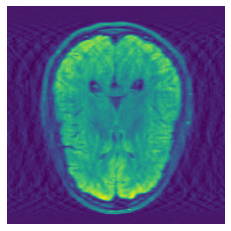

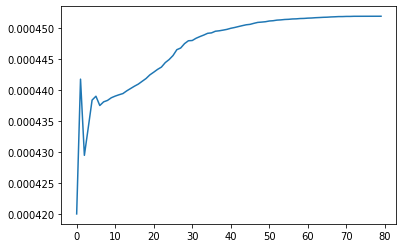

In [5]:
implot(ssos(xf))
plt.plot(costs)